# Classification

## Task 1: Loading and Initial Data Preparation

In this task, we load the weather dataset for Portland, Australia, and perform basic data cleaning. The goal is to prepare the dataset for building a classification model, which will predict whether it will rain the following day.

In [ ]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

In [54]:
# Load data from CSV file into a DataFrame
df = pd.read_csv("weather_Portland.csv")

# Display the first five rows of the DataFrame
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2009-01-01,Portland,12.5,16.6,0.0,4.8,6.5,SW,59.0,SW,...,99.0,1006.7,1010.5,NaN,6.0,13.7,14.5,No,1.6,Yes
1,2009-01-02,Portland,8.6,15.2,1.6,4.8,11.7,SSW,39.0,SW,...,61.0,1020.0,1021.3,6.0,2.0,11.9,14.0,Yes,0.2,No
2,2009-01-03,Portland,1.6,18.0,0.2,4.6,11.9,S,30.0,NE,...,52.0,1020.4,1018.3,6.0,3.0,11.6,17.5,No,0.0,No
3,2009-01-04,Portland,4.8,20.1,0.0,4.8,13.8,S,28.0,E,...,63.0,1016.4,1015.2,1.0,1.0,14.7,18.1,No,0.0,No
4,2009-01-05,Portland,4.4,18.8,0.0,5.6,13.6,W,46.0,W,...,68.0,1014.0,1013.4,4.0,3.0,14.9,18.0,No,0.0,No


In [55]:
# Remove unnecessary columns
columns_to_remove = ["Date", "Location", "Evaporation", "Sunshine", "RainToday", "RISK_MM"]
df.drop(columns=columns_to_remove, inplace=True)

# Check DataFrame columns after removal
df.head()


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,12.5,16.6,0.0,SW,59.0,SW,SW,28.0,28.0,97.0,99.0,1006.7,1010.5,NaN,6.0,13.7,14.5,Yes
1,8.6,15.2,1.6,SSW,39.0,SW,S,20.0,17.0,60.0,61.0,1020.0,1021.3,6.0,2.0,11.9,14.0,No
2,1.6,18.0,0.2,S,30.0,NE,ESE,9.0,15.0,67.0,52.0,1020.4,1018.3,6.0,3.0,11.6,17.5,No
3,4.8,20.1,0.0,S,28.0,E,S,11.0,17.0,73.0,63.0,1016.4,1015.2,1.0,1.0,14.7,18.1,No
4,4.4,18.8,0.0,W,46.0,W,W,20.0,31.0,72.0,68.0,1014.0,1013.4,4.0,3.0,14.9,18.0,No


## Task 2: Imputation and Categorization of Data

In this task, we will handle missing data imputation and transform the atmospheric pressure variables (`Pressure9am`, `Pressure3pm`) into ordinal categories.


In [56]:
# a) Fill missing values for numerical and categorical columns
numeric_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in numeric_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)


In [57]:
# b) Transform data in pressure columns
# Function to categorize pressure values
def pressure_to_category(p):
    if p <= 980:
        return "very_low"
    elif p <= 1000:
        return "low"
    elif p <= 1020:
        return "normal"
    elif p <= 1040:
        return "high"
    else:
        return "very_high"

# Apply transformation to pressure columns
df["Pressure9am"] = df["Pressure9am"].apply(pressure_to_category)
df["Pressure3pm"] = df["Pressure3pm"].apply(pressure_to_category)


## Task 3: Splitting data and handling outliers

In this step, we split the dataset into input features (`X`) and the target variable (`RainTomorrow`). Additionally, we clip outlier values in numerical features to lie within three standard deviations from the mean.


In [58]:
# a) Split data into features (`X`) and labels (`y`)
# Separate target variable from input features
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"].values

# Preview the shape of the resulting datasets
print("X:", X.shape)
print("y:", y.shape)


X: (4897, 17)
y: (4897,)


In [59]:
# b) Clip outlier values of numerical features

numeric_cols = X.select_dtypes(include=["number"]).columns

# Clipping outliers to the range [μ - 3σ, μ + 3σ]
for col in numeric_cols:
    mean = X[col].mean()
    std = X[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)


## Task 4: Data Visualization

In this task, we will create a bar plot showing the distribution of rainy and non-rainy days based on the target variable `y`.



In [60]:
# a) Convert y to pandas Series for visualization
y_series = pd.Series(y)


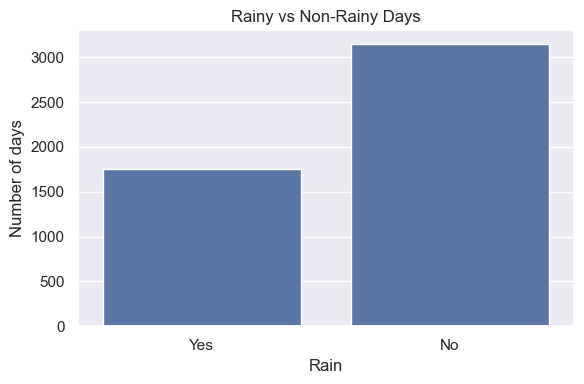

In [61]:
# b) Create bar plot with axis labels and title

# Set the plot theme
sns.set_theme(style="darkgrid")

# Create the bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x=y_series)

# Add labels and title
plt.xlabel("Rain")
plt.ylabel("Number of days")
plt.title("Rainy vs Non-Rainy Days")
plt.tight_layout()

# Show the plot
plt.show()

# The "No" class clearly dominates


## Task 5: Encoding and Feature Scaling

In this task, we encode categorical variables and normalize numerical features. This is a crucial step before training classification models.


In [62]:
# a) Encode ordinal features (pressure)
pressure_order = ["very_low", "low", "normal", "high", "very_high"]

encoder = OrdinalEncoder(categories=[pressure_order, pressure_order])

X[["Pressure9am", "Pressure3pm"]] = encoder.fit_transform(X[["Pressure9am", "Pressure3pm"]])

# Convert encoded values to integers
X[["Pressure9am", "Pressure3pm"]] = X[["Pressure9am", "Pressure3pm"]].astype(int)

X.head()


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,12.5,16.6,0.0,SW,59.0,SW,SW,28.0,28.0,97.0,99.0,2,2,8.0,6.0,13.7,14.5
1,8.6,15.2,1.6,SSW,39.0,SW,S,20.0,17.0,60.0,61.0,2,3,6.0,2.0,11.9,14.0
2,1.6,18.0,0.2,S,30.0,NE,ESE,9.0,15.0,67.0,52.0,3,2,6.0,3.0,11.6,17.5
3,4.8,20.1,0.0,S,28.0,E,S,11.0,17.0,73.0,63.0,2,2,1.0,1.0,14.7,18.1
4,4.4,18.8,0.0,W,46.0,W,W,20.0,31.0,72.0,68.0,2,2,4.0,3.0,14.9,18.0


In [63]:
# b) Encode nominal categorical features (one-hot encoding)

# Select nominal categorical features (all object type columns)
nominal_cols = X.select_dtypes(include=["object"]).columns

# Apply one-hot encoding and drop original columns
X = pd.get_dummies(X, columns=nominal_cols)

X.head()


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,12.5,16.6,0.0,59.0,28.0,28.0,97.0,99.0,2,2,...,False,False,False,False,False,False,True,False,False,False
1,8.6,15.2,1.6,39.0,20.0,17.0,60.0,61.0,2,3,...,False,False,True,False,False,False,False,False,False,False
2,1.6,18.0,0.2,30.0,9.0,15.0,67.0,52.0,3,2,...,False,False,False,False,False,False,False,False,False,False
3,4.8,20.1,0.0,28.0,11.0,17.0,73.0,63.0,2,2,...,False,False,True,False,False,False,False,False,False,False
4,4.4,18.8,0.0,46.0,20.0,31.0,72.0,68.0,2,2,...,False,False,False,False,False,False,False,True,False,False


In [64]:
# c) Encode target labels

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [65]:
# d) Normalize feature values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Show min and max values before scaling
print(X.describe().T[["min", "max"]])


                     min         max
MinTemp        -1.303098   20.307223
MaxTemp         9.000000   33.343979
Rainfall        0.000000   17.843756
WindGustSpeed  13.000000   87.023556
WindSpeed9am    0.000000   40.970822
WindSpeed3pm    0.000000   46.310479
Humidity9am    37.044472  100.000000
Humidity3pm    20.818126  100.000000
Pressure9am     1.000000    3.000000
Pressure3pm     1.000000    3.000000
Cloud9am        0.799304    8.000000
Cloud3pm        0.283568    8.000000
Temp9am         1.777933   24.361826
Temp3pm         5.200000   30.872910


## Task 6: Train-Test Split and Training of Classifiers

In this task, we prepare the dataset for training and train several binary classifiers that predict whether it will rain tomorrow (`RainTomorrow`).


In [66]:
# a) Split the data into training and test sets
print("Any NaN in X?", np.isnan(X_scaled).any())

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)


Any NaN in X? False


In [67]:
# b) Train multiple classifiers

# We train five different models:
# - K-Nearest Neighbors (default parameters)
# - Decision Tree (max_depth=4)
# - Logistic Regression (no penalty)
# - SVM with linear kernel (C=1000)
# - SVM with RBF kernel (default parameters)

# Initialize models
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(max_depth=4),
    "LogisticRegression": LogisticRegression(penalty=None, max_iter=1000),
    "SVM_Linear": SVC(kernel='linear', C=1e3),
    "SVM_RBF": SVC(kernel='rbf')
}

# Dictionaries to store predictions
y_train_preds = {}
y_test_preds = {}

# Train and predict with each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_preds[name] = model.predict(X_train)
    y_test_preds[name] = model.predict(X_test)


In [68]:
# Extract the logistic regression model
model = models["LogisticRegression"]
weights = model.coef_

# Convert the weights to a readable DataFrame with feature names
feature_weights = pd.DataFrame({
    "feature": X.columns,
    "weight": model.coef_[0]
}).sort_values(by="weight", key=abs, ascending=False)

# Show top 10 most influential features (absolute weight)
feature_weights.head(10)

# Interpretation:
# - Positive weights indicate features associated with "Yes" (rain tomorrow).
# - Negative weights indicate features associated with "No" (no rain tomorrow).
# - The greater the absolute value of a weight, the stronger the influence of that feature on the prediction.



,feature,weight
7,Humidity3pm,5.463419
3,WindGustSpeed,5.203347
12,Temp9am,-1.901575
13,Temp3pm,1.858097
9,Pressure3pm,-1.519674
1,MaxTemp,-1.501206
4,WindSpeed9am,-1.128152
2,Rainfall,0.876958
56,WindDir3pm_SSE,-0.845876
55,WindDir3pm_SE,-0.751259


In [69]:
# Extract the decision tree model
tree_model = models["DecisionTree"]

# Generate a text-based summary of the decision rules
tree_rules = export_text(tree_model, feature_names=list(X.columns))
print(tree_rules)

# Interpretation:
# - The tree structure shows how decisions are made based on feature thresholds.
# - Each level represents a split on a specific feature and value.
# - The leaf nodes indicate the predicted class and the number of training samples in each class.
# - This is useful for understanding the logic behind the tree's decisions and identifying key splitting features.


|--- WindGustSpeed <= 0.54
|   |--- Humidity3pm <= 0.73
|   |   |--- Humidity3pm <= 0.58
|   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |--- class: 0
|   |   |   |--- WindGustSpeed >  0.36
|   |   |   |   |--- class: 0
|   |   |--- Humidity3pm >  0.58
|   |   |   |--- WindGustSpeed <= 0.34
|   |   |   |   |--- class: 0
|   |   |   |--- WindGustSpeed >  0.34
|   |   |   |   |--- class: 0
|   |--- Humidity3pm >  0.73
|   |   |--- Humidity3pm <= 0.83
|   |   |   |--- WindGustSpeed <= 0.26
|   |   |   |   |--- class: 0
|   |   |   |--- WindGustSpeed >  0.26
|   |   |   |   |--- class: 1
|   |   |--- Humidity3pm >  0.83
|   |   |   |--- WindDir9am_S <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- WindDir9am_S >  0.50
|   |   |   |   |--- class: 0
|--- WindGustSpeed >  0.54
|   |--- Humidity3pm <= 0.55
|   |   |--- Temp9am <= 0.41
|   |   |   |--- MinTemp <= 0.31
|   |   |   |   |--- class: 0
|   |   |   |--- MinTemp >  0.31
|   |   |   |   |--- class: 1
|   |   |--- Temp9am >

## Task 7: Classification Performance Evaluation

In this task, we evaluate the performance of the trained classification models using the following quality metrics: accuracy, precision, and recall. The results will be presented in a summary table.


In [70]:
# a) Calculate performance metrics for each model

results = []

for name in models.keys():
    acc_train = accuracy_score(y_train, y_train_preds[name])
    acc_test = accuracy_score(y_test, y_test_preds[name])
    prc_train = precision_score(y_train, y_train_preds[name])
    prc_test = precision_score(y_test, y_test_preds[name])
    rcl_train = recall_score(y_train, y_train_preds[name])
    rcl_test = recall_score(y_test, y_test_preds[name])
    
    results.append([name, acc_train, acc_test, prc_train, prc_test, rcl_train, rcl_test])


In [71]:
# b) Create a DataFrame to display the results
metrics_df = pd.DataFrame(results, columns=[
    "Model", "acc_train", "acc_test", "prc_train", "prc_test", "rcl_train", "rcl_test"
])

# Display the results table
metrics_df.set_index("Model", inplace=True)
metrics_df


,acc_train,acc_test,prc_train,prc_test,rcl_train,rcl_test
Model,,,,,,
KNN,0.812612,0.725510,0.781513,0.639456,0.662393,0.535613
DecisionTree,0.792188,0.760204,0.793241,0.721374,0.568376,0.538462
LogisticRegression,0.799847,0.788776,0.757475,0.723602,0.649573,0.663818
SVM_Linear,0.798315,0.796939,0.760169,0.742038,0.638889,0.663818
SVM_RBF,0.833801,0.790816,0.820972,0.744966,0.685897,0.632479


Best model: SVM_Linear


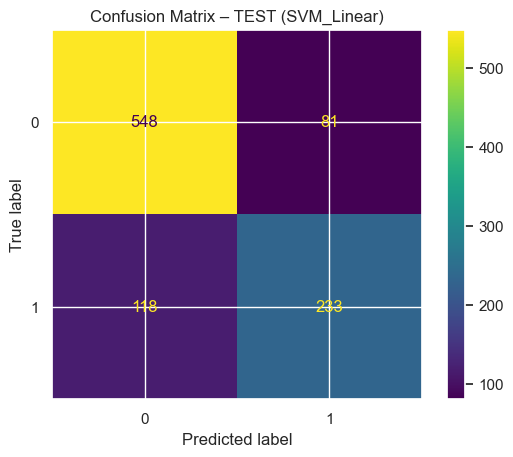

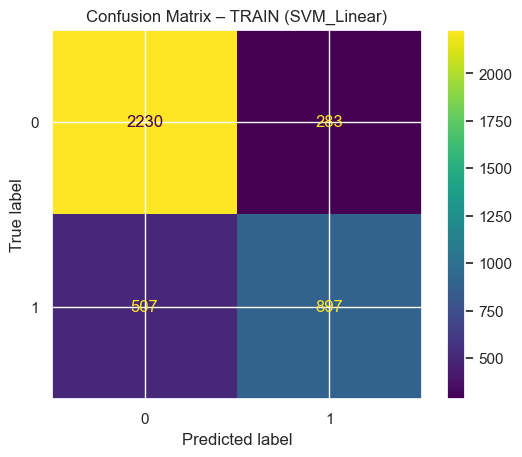

In [ ]:
# c) Confusion matrix for the best model

# Select the best model based on test accuracy
best_model_name = metrics_df["acc_test"].idxmax()
best_train_preds = y_train_preds[best_model_name]
best_test_preds = y_test_preds[best_model_name]

print(f"Best model: {best_model_name}")

conf_matrix_train = confusion_matrix(y_train, best_train_preds)
conf_matrix_test = confusion_matrix(y_test, best_test_preds)

# For test set
disp = ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title(f"Confusion Matrix – TEST ({best_model_name})")
plt.show()

# For training set
disp = ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title(f"Confusion Matrix – TRAIN ({best_model_name})")
plt.show()


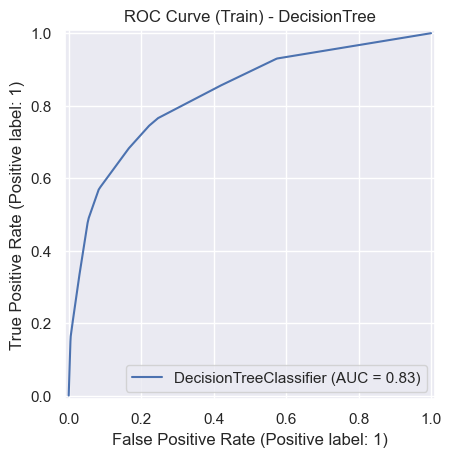

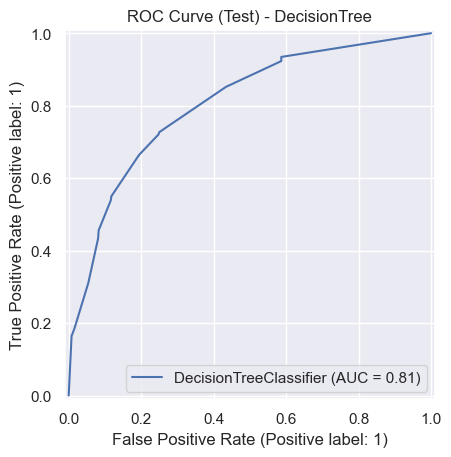

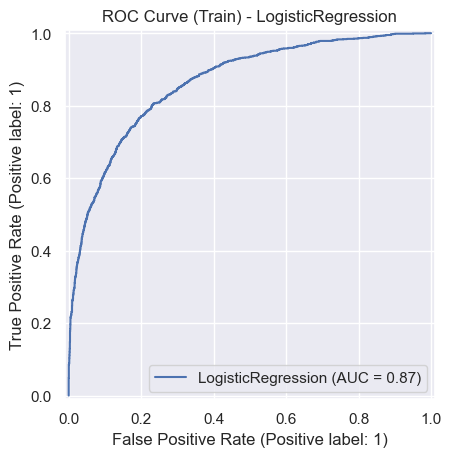

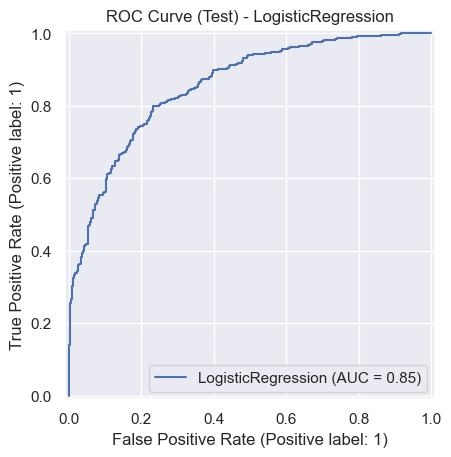

In [ ]:
# d) ROC curves and AUC for selected models

# For selected models (DecisionTree and LogisticRegression), we plot ROC curves for the training and test sets.
# We use RocCurveDisplay, which automatically computes and shows the AUC value (Area Under the Curve).

selected_models = ["DecisionTree", "LogisticRegression"]

for name in selected_models:
    model = models[name]
    
    # Training set
    RocCurveDisplay.from_estimator(model, X_train, y_train)
    plt.title(f"ROC Curve (Train) - {name}")
    plt.show()

    # Test set
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve (Test) - {name}")
    plt.show()


## 📝 Final Conclusions After Evaluating Classification Models

The ROC curves illustrate how well each model distinguishes between the "Yes" and "No" classes in the binary classification task.

A significant difference in AUC between the training and test sets may indicate overfitting.

The Logistic Regression model shows better generalization performance than the Decision Tree.
